# Advanced Machine Learning. Домашнее задание 2

Data: https://ourworldindata.org/coronavirus-source-data

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os

if not os.path.exists('owid-covid-data.csv'):
    !pip install wget
    
    import wget
    filename = wget.download('https://covid.ourworldindata.org/data/owid-covid-data.csv')

data = pd.read_csv('owid-covid-data.csv')

### Задание 1

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная
с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве
целевой переменной возьмём число случаев заболевания (столбцы total_cases и
new_cases); для упрощения обработки можно заменить в столбце new_cases все
нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в
виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно
использовать в качестве тестового набора (и он даже будет увеличиваться по мере
выполнения задания).

In [3]:
df = data[data['location'] == 'Russia'].copy()

In [4]:
df.date = pd.to_datetime(df.date)

Рассматриваемый период: с 3 марта 2020 по 11 мая 2020 включительно (дата выполнени дз)

In [5]:
df = df[(df.date >= pd.to_datetime('2020-03-03')) &
    (df.date <= pd.to_datetime('2020-05-11'))]
df = df[['date', 'total_cases', 'new_cases']]

In [6]:
df.new_cases[df.new_cases == 0] = 1

In [7]:
df

,date,total_cases,new_cases
13289,2020-03-03,3,1
13290,2020-03-04,4,1
13291,2020-03-05,4,1
13292,2020-03-06,4,1
13293,2020-03-07,10,6
...,...,...,...
13354,2020-05-07,165929,10559
13355,2020-05-08,177160,11231
13356,2020-05-09,187859,10699
13357,2020-05-10,198676,10817


In [8]:
X = np.arange(df.shape[0])
y_total = df.total_cases
y_new = df.new_cases

In [9]:
X_train = X[:50]
y_train_total = y_total[:50]
y_train_new = y_new[:50]

X_test = X[50:]
y_test_total = y_total[50:]
y_test_new = y_new[50:]

### Задание 2

Постройте графики целевых переменных. Вы увидите, что число заболевших
растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к
снаряду давайте это и используем.

1. Используя линейную регрессию, обучите модель с экспоненциальным
ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер
текущего дня.
2. Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели (это фактически первый шаг
эмпирического Байеса).
3. Посэмплируйте много разных экспонент, постройте графики. Сколько,
исходя из этих сэмплов, предсказывается случаев коронавируса в России к
1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения
(можно эмпирически, исходя из данных сэмплирования).


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

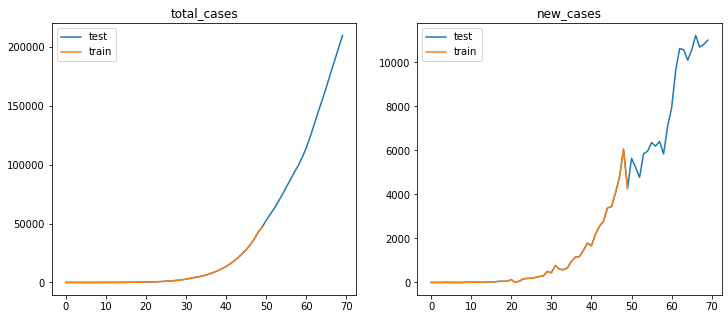

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(X, y_total, label='test')
ax1.plot(X_train, y_train_total, label='train')
ax1.set_title('total_cases')
ax1.legend()
ax2.plot(X, y_new, label='test')
ax2.plot(X_train, y_train_new, label='train')
ax2.set_title('new_cases')
ax2.legend()
plt.show()

**Часть 1**

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [12]:
y_train_total_ln = np.log(y_train_total)
y_test_total_ln = np.log(y_test_total)

In [13]:
def add_ones(matr):
    return np.stack([np.ones(matr.shape[0]), matr], axis=-1)

In [14]:
X = add_ones(X)
X_train = add_ones(X_train)
X_test = add_ones(X_test)

In [15]:
alphas = np.arange(500, 10001, 500)

In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

best_alpha = -1
best_train = 1e18
for alpha in alphas:
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X_train, y_train_total_ln)
    train_error = np.sqrt(mean_squared_error(y_train_total, np.exp(model.predict(X_train))))
    test_error = np.sqrt(mean_squared_error(y_test_total, np.exp(model.predict(X_test))))
    print(f'alpha = {alpha}, train_error={train_error}, test_error={test_error}')
    
    if best_train > train_error:
        best_train = train_error
        best_alpha = alpha

alpha = 500, train_error=23570.630561930186, test_error=7466620.363825607
alpha = 1000, train_error=19081.838492066578, test_error=6217619.419945571
alpha = 1500, train_error=15117.743184291548, test_error=5133538.104974659
alpha = 2000, train_error=11733.634642279549, test_error=4241348.601762063
alpha = 2500, train_error=8882.233900665526, test_error=3512409.1902216016
alpha = 3000, train_error=6530.259376013918, test_error=2916604.7713138703
alpha = 3500, train_error=4696.125408348911, test_error=2428358.957608028
alpha = 4000, train_error=3497.876825670721, test_error=2026915.1627544165
alpha = 4500, train_error=3119.4909372215884, test_error=1695646.8446711444
alpha = 5000, train_error=3478.7520109718234, test_error=1421278.2778982793
alpha = 5500, train_error=4198.729168407529, test_error=1193203.5365408224
alpha = 6000, train_error=5011.005763014025, test_error=1002931.450865946
alpha = 6500, train_error=5805.621896160799, test_error=843644.5305238126
alpha = 7000, train_error=6

In [17]:
best_alpha

4500

In [18]:
model = Ridge(alpha=best_alpha, fit_intercept=False)
model.fit(X_train, y_train_total_ln)

Ridge(alpha=4500, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

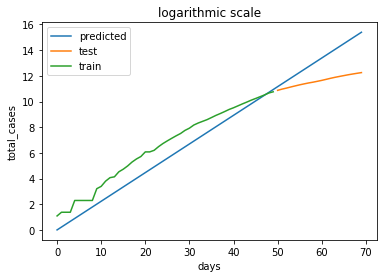

In [19]:
plt.plot(X[:, 1], model.predict(X), label='predicted')
plt.plot(X_test[:, 1], y_test_total_ln, label='test')
plt.plot(X_train[:, 1], np.log(y_train_total), label='train')
plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend()
plt.title('logarithmic scale')
plt.show()

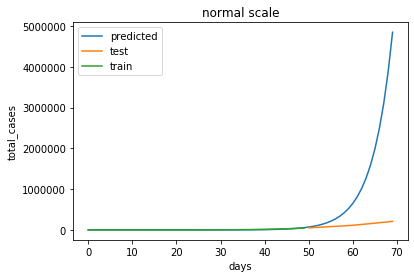

In [20]:
plt.plot(X[:, 1], np.exp(model.predict(X)), label='predicted')
plt.plot(X_test[:, 1], y_test_total, label='test')
plt.plot(X_train[:, 1], y_train_total, label='train')
plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend()
plt.title('normal scale')
plt.show()

**Часть 2**

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

$$
\begin{align}
& p(w)=\mathcal{N}(w|\mu_0, \Sigma_0)\\
& p(w|D)=\mathcal{N}(w|\mu_N, \Sigma_N)\\
& \mu_N = \Sigma_N\left(\Sigma^{-1}_0\mu_0+\frac{1}{\sigma^2}X^Tln(y)\right)\\
& \Sigma_N = \left(\Sigma^{-1}_0+\frac{1}{\sigma^2}X^TX\right)^{-1}\\
& \sigma - \text{шум в данных}
\end{align}
$$

In [21]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), np.array(y)))
    return mu_n, sigma_n

In [22]:
noise = np.std(np.array(y_train_total_ln) - model.predict(X_train))
noise

0.4575168628713691

Априорное распределение для гребневой регрессии:

$$p(w)=\mathcal{N}(w|0, \sigma_0^2I)$$

Т. к. регуляяризатор $\alpha=\frac{\sigma^2}{\sigma_0^2}$, получаем $\sigma_0^2=\frac{\sigma^2}{\alpha}$.

In [23]:
s = noise ** 2 / best_alpha # best_alpha = 4500
s

4.651592884703537e-05

In [24]:
def get_mu_sigma(X_train, y_train, s, noise):
    mu_0 = np.zeros(X_train.shape[1])
    sigma_0 = s * np.eye(X_train.shape[1])
    mu_n, sigma_n = bayesian_update(mu_0, sigma_0, X_train, y_train, noise)
    return mu_n, sigma_n

In [25]:
mu, sigma = get_mu_sigma(X_train, np.log(y_train_total), s, noise)
print('mu =', mu)
print('sigma =', sigma)

mu = [0.01095732 0.22294732]
sigma = [[ 4.63449971e-05 -1.26372001e-06]
 [-1.26372001e-06  4.69381718e-06]]


**Часть 3**

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [26]:
def sample_lines(mu, sigma, n=20):
    ws = np.random.multivariate_normal(mu, sigma, n)
    
    for w in ws:
        plt.plot(X[:, 1], np.exp(X.dot(w)), 'k-', lw=.4)
    plt.plot(X_test[:, 1], np.exp(model.predict(X_test)), lw=2, label='predicted')
    plt.plot(X[:, 1], y_total, label='train + test', lw=2)
    plt.xlabel('days')
    plt.ylabel('total_cases')
    plt.legend()

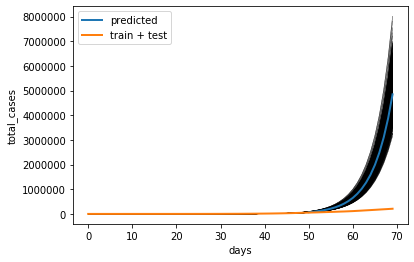

In [27]:
sample_lines(mu, sigma, 1000)

In [28]:
def get_preds(mu, sigma, date, n=20):
    days = (pd.to_datetime(date) - pd.to_datetime('2020-03-03')).days + 1
    ws = np.random.multivariate_normal(mu, sigma, n)
    preds = np.exp(ws[:, 0] + ws[:, 1] * days)
    plt.hist(preds, bins=30)
    print(f'total_cases in Russia on {date} is {preds.mean()}')

total_cases in Russia on 2020-05-01 is 658712.866168944


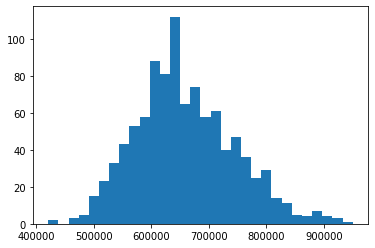

In [29]:
get_preds(mu, sigma, '2020-05-01', 1000)

total_cases in Russia on 2020-06-01 is 664954220.6583637


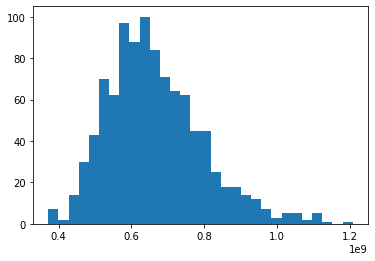

In [30]:
get_preds(mu, sigma, '2020-06-01', 1000)

total_cases in Russia on 2020-09-01 is 5.796509599054035e+17


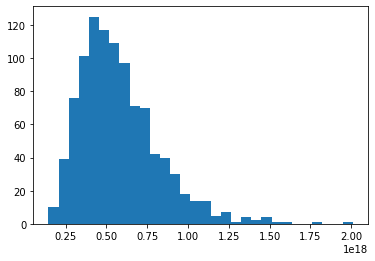

In [31]:
get_preds(mu, sigma, '2020-09-01', 1000)

### Задание 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это,
конечно, чересчур пессимистично — экспоненциальный рост в природе никак не
может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в
реальности имеет сигмоидальный вид: после начальной фазы экспоненциального
роста неизбежно происходит насыщение. В качестве конкретной формы такой
сигмоиды давайте возьмём форму функции распределения для гауссиана $\Phi(x)=\int_{-\infty}^xe^{-\frac{t^2}{2}}dt$.

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа
перед интегралом может быть произвольной (и её можно внести в экспоненту), а в
экспоненте под интегралом может быть произвольная квадратичная функция от t.
1. Предложите способ обучать параметры такой сигмоидальной функции при
помощи линейной регрессии.
2. Обучите эти параметры на датасете случаев коронавируса в России.
Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели.
3. Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?


**Часть 1**

Предложите способ обучать параметры такой сигмоидальной функции при
помощи линейной регрессии.

Будем обучать new_cases $f(x) = e^{ax^2 + bx + c}$, а затем получим total_cases как $\sum_{i=0}^xf(x)$.

**Часть 2**

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [32]:
def get_polinomial(X):
    return np.stack([np.ones(X.shape[0]), X[:, 1], X[:, 1] ** 2], axis=-1)

In [33]:
X = get_polinomial(X)
X_train = get_polinomial(X_train)
X_test = get_polinomial(X_test)

In [34]:
y_train_new_ln = np.log(y_train_new)
y_test_new_ln = np.log(y_test_new)

In [35]:
alphas = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07] 

In [36]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

best_alpha = -1
best_train = 1e18
for alpha in alphas:
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X_train, y_train_new_ln)
    train_error = np.sqrt(mean_squared_error(y_train_new, np.exp(model.predict(X_train))))
    test_error = np.sqrt(mean_squared_error(y_test_new, np.exp(model.predict(X_test))))
    print(f'alpha = {alpha}, train_error={train_error}, test_error={test_error}')
    
    if best_train > train_error:
        best_train = train_error
        best_alpha = alpha

alpha = 0.001, train_error=314.44365123006935, test_error=15767.381568247818
alpha = 0.003, train_error=314.4971570382629, test_error=15775.098188576185
alpha = 0.005, train_error=314.55064615403893, test_error=15782.812494066275
alpha = 0.007, train_error=314.60411857205804, test_error=15790.524485402484
alpha = 0.01, train_error=314.68429587934355, test_error=15802.088134879281
alpha = 0.03, train_error=315.21784956355145, test_error=15879.046279016013
alpha = 0.05, train_error=315.7497272376498, test_error=15955.773871400197
alpha = 0.07, train_error=316.27992435573714, test_error=16032.271606950022


In [37]:
best_alpha

0.001

In [38]:
model = Ridge(alpha=best_alpha, fit_intercept=False)
model.fit(X_train, y_train_new_ln)

Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

После 50 точки в данных (22 апреля) происходит смещение изменение скорости роста числа заболевших. Для сравнения добавим в train 10 точек и обучим ту же модель:

In [39]:
model10 = Ridge(alpha=best_alpha, fit_intercept=False)
model10.fit(X[:60, :], np.log(y_new[:60]))

Ridge(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

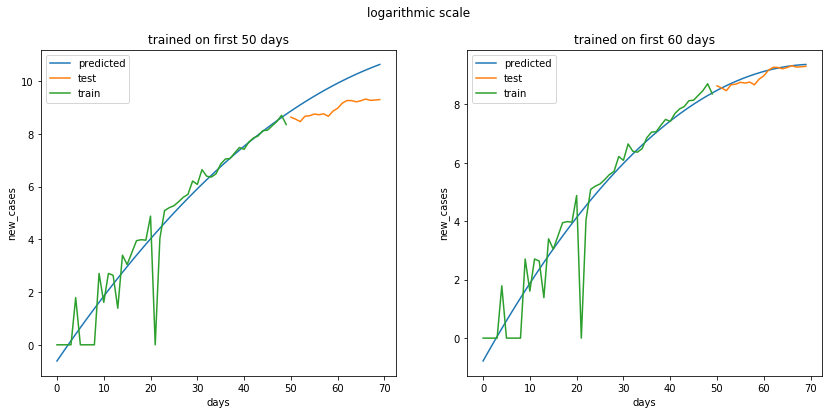

In [40]:
def plot_new_cases_log_scale(model, ax):
    ax.plot(X[:, 1], model.predict(X), label='predicted')
    ax.plot(X_test[:, 1], y_test_new_ln, label='test')
    ax.plot(X_train[:, 1], y_train_new_ln, label='train')
    ax.set(xlabel='days', ylabel='new_cases')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plot_new_cases_log_scale(model, ax1)
plot_new_cases_log_scale(model10, ax2)
ax1.set(title='trained on first 50 days')
ax2.set(title='trained on first 60 days')
fig.suptitle('logarithmic scale')
plt.show()

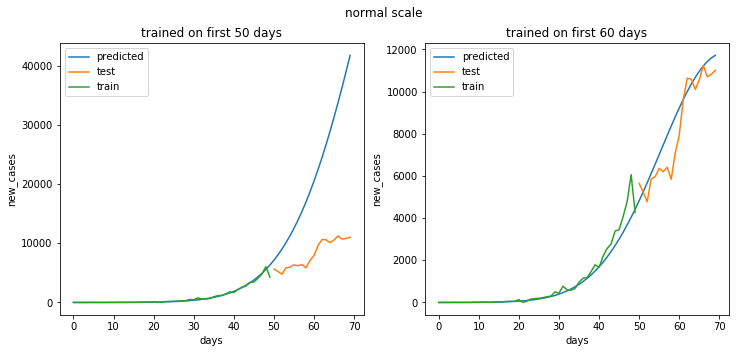

In [41]:
def plot_new_cases_norm_scale(model, ax):
    ax.plot(X[:, 1], np.exp(model.predict(X)), label='predicted')
    ax.plot(X_test[:, 1], y_test_new, label='test')
    ax.plot(X_train[:, 1], y_train_new, label='train')
    ax.set(xlabel='days', ylabel='new_cases')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_new_cases_norm_scale(model, ax1)
plot_new_cases_norm_scale(model10, ax2)
ax1.set(title='trained on first 50 days')
ax2.set(title='trained on first 60 days')
fig.suptitle('normal scale')
plt.show()

In [42]:
def get_total_cases(model, X):
    preds = model.predict(X)
    preds = np.exp(preds)
    return np.tril(np.ones((preds.shape[0], preds.shape[0]))).dot(preds)

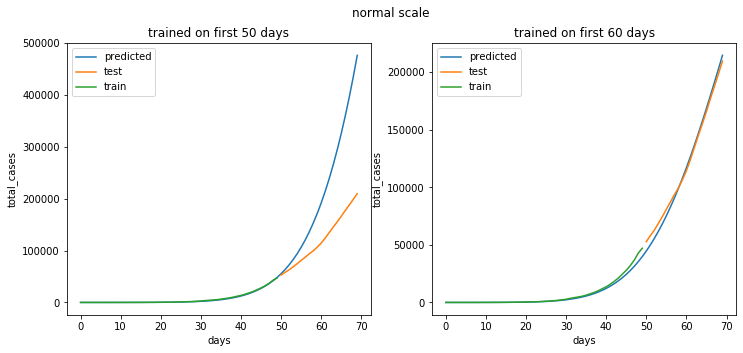

In [43]:
def plot_total_cases_norm_scale(model, ax):
    ax.plot(X[:, 1], get_total_cases(model, X), label='predicted')
    ax.plot(X_test[:, 1], y_test_total, label='test')
    ax.plot(X_train[:, 1], y_train_total, label='train')
    ax.set(xlabel='days', ylabel='total_cases')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_total_cases_norm_scale(model, ax1)
plot_total_cases_norm_scale(model10, ax2)
ax1.set(title='trained on first 50 days')
ax2.set(title='trained on first 60 days')
fig.suptitle('normal scale')
plt.show()

In [44]:
noise = np.std(np.array(y_train_new_ln) - model.predict(X_train))
s = noise ** 2 / best_alpha # best_alpha = 0.001
mu, sigma = get_mu_sigma(X_train, y_train_new_ln, s, noise)
print('trained on first 50 days:')
print(f'noise={noise}, s={s}')
print('mu =', mu)
print('sigma =', sigma)

trained on first 50 days:
noise=0.7883791480796739, s=621.5416811268324
mu = [-0.61404074  0.25981723 -0.00140182]
sigma = [[ 1.03366731e-01 -8.35144370e-03  1.40596667e-04]
 [-8.35144370e-03  9.20877554e-04 -1.75756207e-05]
 [ 1.40596667e-04 -1.75756207e-05  3.58692923e-07]]


In [45]:
noise10 = np.std(np.log(np.array(y_new[:60])) - model.predict(X[:60, :]))
s10 = noise10 ** 2 / best_alpha
mu10, sigma10 = get_mu_sigma(X[:60, :], np.log(y_new[:60]), s10, noise10)
print('trained on first 60 days:')
print(f'noise={noise10}, s={s10}')
print('mu =', mu10)
print('sigma =', sigma10)

trained on first 60 days:
noise=0.7700876037884882, s=593.0349175086955
mu = [-0.78214912  0.28569423 -0.00200838]
sigma = [[ 8.32671660e-02 -5.59713264e-03  7.83912045e-05]
 [-5.59713264e-03  5.11426582e-04 -8.10983470e-06]
 [ 7.83912045e-05 -8.10983470e-06  1.37457011e-07]]


**Часть 3**

Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [46]:
def get_total_cases_from_coef(X, w):
    preds = np.exp(X.dot(w))
    return np.tril(np.ones((preds.shape[0], preds.shape[0]))).dot(preds)

In [47]:
def sample_sigmoidslines(model, X_extended, mu, sigma, days_cnt, n=20):
    ws = np.random.multivariate_normal(mu, sigma, n)
    
    for w in ws:
        plt.plot(X_extended[:, 1], get_total_cases_from_coef(X_extended, w), 'k-', lw=.07)
    plt.plot(X_extended[:, 1], get_total_cases(model, X_extended), lw=2, label='predicted')
    plt.plot(X[:, 1], y_total, label='train + test', lw=2)
    plt.xlabel('days')
    plt.ylabel('total_cases')
    plt.ylim((0, 1e6))
    plt.title(f'trained on first {days_cnt} days')
    plt.legend()

In [48]:
X_extended = get_polinomial(add_ones(np.arange(150)))

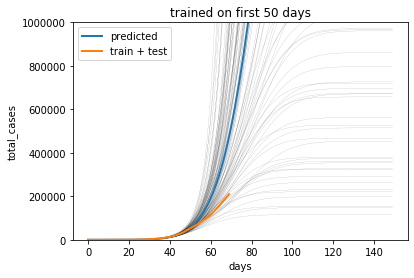

In [49]:
sample_sigmoidslines(model, X_extended, mu, sigma, 50, 100)

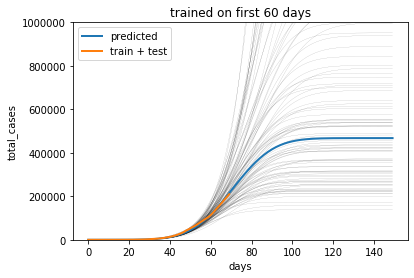

In [50]:
sample_sigmoidslines(model10, X_extended, mu10, sigma10, 60, 100)

In [51]:
preds = get_total_cases(model10, X_extended)

In [52]:
print('Total cases in Russia:', preds[-1])

Total cases in Russia: 467671.57775765314


In [53]:
def get_preds(mu, sigma, n=20):
    ws = np.random.multivariate_normal(mu, sigma, n)
    preds = np.exp(X_extended.dot(np.transpose(ws)))
    preds = np.tril(np.ones((preds.shape[0], preds.shape[0]))).dot(preds)
    preds = preds[-1, :]
    preds = preds[preds < 1e6]
    plt.hist(preds, bins=15)
    print(f'Total cases in Russia is {preds.mean()}')
    return preds

Total cases in Russia is 452870.04441522114


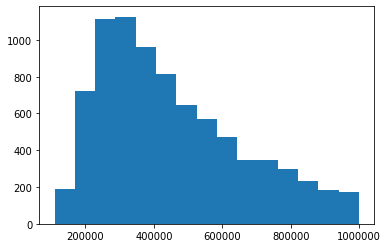

In [54]:
preds = get_preds(mu10, sigma10, 10000)

In [55]:
print(f'90-percentile {np.percentile(preds, 90)}')

90-percentile 775125.8458302275


In [56]:
print(f'10-percentile {np.percentile(preds, 10)}')

10-percentile 222051.3973122778


### Задание 4

Бонус: проведите такой же анализ для других стран (здесь придётся руками
подобрать дни начала моделирования — коронавирус приходил в разные страны в
разное время). Насколько разные параметры получаются? Можно ли разделить
страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?


In [57]:
countries = ['France', 'Italy', 'Germany', 'Russia', 'Brazil', 'Belarus', 'Sweden',
             'South Korea', 'Japan', 'Czech Republic', 'Poland', 'Latvia']

In [58]:
X_extended = get_polinomial(add_ones(np.arange(200)))

France, train_error=1279.2659568747433
Italy, train_error=1229.811858657246
Germany, train_error=1570.545363926552
Russia, train_error=614.8124624199241
Brazil, train_error=1045.4138191297375
Belarus, train_error=273.4460733212905
Sweden, train_error=139.79276441507088
South Korea, train_error=173.48491996211936
Japan, train_error=177.84219341501628
Czech Republic, train_error=73.05742588978123
Poland, train_error=94.09116307364245
Latvia, train_error=11.977186629575506


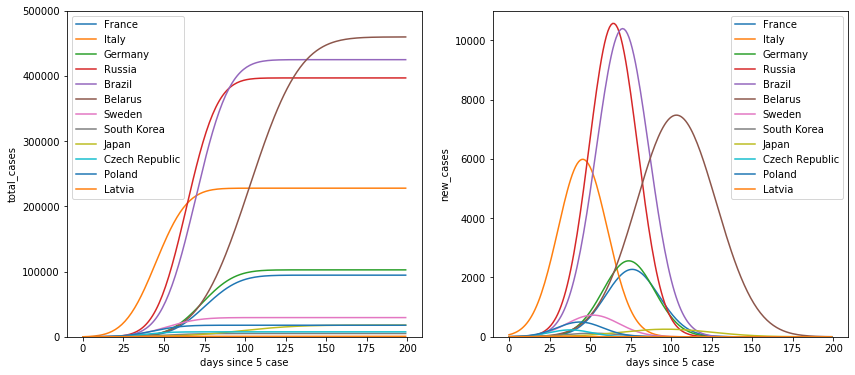

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
for location in countries:
    df = data[data['location'] == location].copy()
    df = df[['date','total_cases', 'new_cases']]
    df.date = pd.to_datetime(df.date)
    df = df[df.total_cases >= 5]
    df = df[df.date <= pd.to_datetime('2020-05-11')]
    
    X = np.arange(df.shape[0])
    y_total = df.total_cases
    y_new = np.array(df.new_cases)
    y_new[y_new == 0] = 1
    
    X = get_polinomial(add_ones(X))
    y_total_ln = np.array(np.log(y_total))
    y_new_ln = np.array(np.log(y_new))
    
    alphas = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 1, 2, 5, 10, 50, 100, 150, 500, 1000, 1500]
    
    best_alpha = -1
    best_train = 1e18
    for alpha in alphas:
        model = Ridge(alpha=alpha, fit_intercept=False)
        model.fit(X, y_new_ln)
        train_error = np.sqrt(mean_squared_error(y_new, np.exp(model.predict(X))))
        
        if best_train > train_error:
            best_train = train_error
            best_alpha = alpha
            
    print(f'{location}, train_error={best_train}')
    
    model = Ridge(alpha=best_alpha, fit_intercept=False)
    model.fit(X, y_new_ln)
    ax1.plot(X_extended[:, 1], get_total_cases(model, X_extended), label=location)
    ax2.plot(X_extended[:, 1], np.exp(model.predict(X_extended)), label=location)
ax1.legend()
ax2.legend()
ax1.set(xlabel='days since 5 case', ylabel='total_cases', ylim=((0, 5e5)))
ax2.set(xlabel='days since 5 case', ylabel='new_cases', ylim=((0, 1.1e4)))
plt.show()

Можно объединить страны с одного и того же региона (Южная Корея и Япония; Германия и Франция; Чехия, Польша, Латвия). У них схожая скорость распространения, а также количество зараженных.

### Задание 5

Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам
такого моделирования? Как принять решение, например, о том, нужно ли вводить
карантин?

На данном этапе развития пандемии сигмоида хорошо описывает данные, однако она не учитывает такие факты, как введение карантинных мероприятий, а также степень их строгости. По ней нельзя принять решение о введении карантина. Так же будет затруднительным прогнозирование развития пандемии в случаях снятия или ослабления карантина, а также повторной вспышки.